In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import gc
import re
import csv
import os
import torch
import Stemmer
import pandas as pd
from tqdm import tqdm
from typing import Any, Dict, Iterator, List, Mapping, Optional
from langchain_core.callbacks.manager import CallbackManagerForChainRun
from langchain_core.language_models import BaseLanguageModel
from langchain_core.prompts import BasePromptTemplate
from langchain_community.graphs.networkx_graph import get_entities
from langchain.chains import GraphQAChain
from langchain.chains.llm import LLMChain
import bm25s
import networkx as nx
from utils.preprocessing import stemmer, preprocess_text
from utils.graph import KGraphPreproc
from utils.llm.mistral import MistralLLM
from utils.prompt import GRAPH_QA_PROMPT, ENTITY_PROMPT, NO_CONTEXT_PROMPT, EVALUATE_CONTEXT_PROMPT

In [3]:
fbqa = pd.read_json("/datasets/FreebaseQA/FreebaseQA-eval.json")
fbkb_graph = KGraphPreproc.get_fbkb_graph()

In [ ]:
nodes = fbkb_graph._graph.number_of_nodes()
edges = fbkb_graph._graph.number_of_edges()

In [8]:
edges/nodes

17.097242280448388

In [24]:
deg_dict = dict(fbkb_graph._graph.degree())
deg_df = pd.DataFrame(
    list(deg_dict.items()),
    columns=["Node", "Degree"]
)
deg_df.head()

,Node,Degree
0,/m/027rn,49
1,/m/06cx9,84
2,/m/017dcd,10
3,/m/06v8s0,12
4,/m/07s9rl0,1301


In [30]:
fbkb_graph.mid2name["/m/09c7w0"]

'United_States_of_America'

In [40]:
deg_df[deg_df.Degree>250].sort_values(by="Degree")

,Node,Degree
597,/m/01vj9c,254
4709,/m/03bwzr4,259
1302,/m/015qh,261
2940,/m/01g5v,264
2149,/m/04kxsb,266
...,...,...
90,/m/09nqf,3275
141,/m/05zppz,3567
434,/m/04ztj,3679
62,/m/08mbj5d,4364


In [38]:
deg_df[deg_df.Degree>300].describe()

,Degree
count,127.000000
mean,731.062992
std,877.439165
min,301.000000
25%,384.000000
50%,462.000000
75%,714.500000
max,6953.000000


<Axes: ylabel='Frequency'>

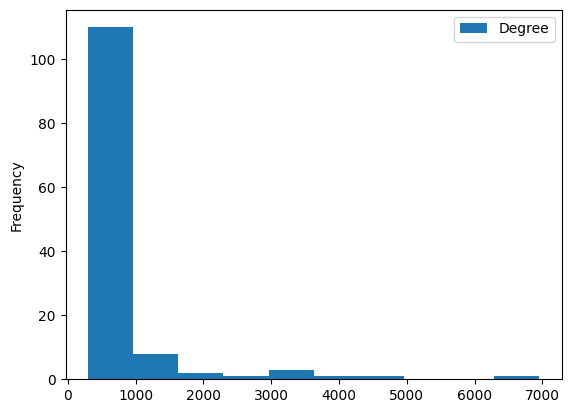

In [37]:
deg_df[deg_df.Degree>300].plot.hist()

In [ ]:
max_triplets = 250

top_triplets = []
for edge_set in node.edges(partition_into=max_triplet):
    top_triplets.extend_with_top(   rank_triplets(edge_set) )